# Flower project: integrate Pytorch model on Android

Step 3 of my capstone project is implementing the trained model in a mobile app.
In Step 2 I have created my app.
There are few solutions I want to test:
    - convert the model to onnix with Caffe 2 (see my previous notebook Convert Pytorch model to ONNIX)
    - integrate the onnix & Caffe2 converted model into Android App

Tutorials used:
    - https://docs.tvm.ai/tutorials/frontend/deploy_model_on_android.html
    - https://brsoff.github.io/tutorials/advanced/super_resolution_with_caffe2.html
    - https://github.com/wangnamu/AICamera_new
    - on https://developer.android.com/studio/command-line
    - paper: https://arxiv.org/pdf/1609.04802.pdf

STEPS:
    - install Android NDK https://developer.android.com/ndk/guides #download-ndk
    - add NDK and add your SDK and platform tools to the path
    - locate and run your adb shell: 
    *Locate your adb*:
    go to Files, Project Structure
    select SDK Location: go to the path
    the adb is located under ..AppData\Local\Android\Sdk\platform-tools
        adb: Android Debug Bridge (adb) is a versatile command-line tool that lets you communicate with a device. The adb command facilitates a variety of device actions, such as installing and debugging apps, and it provides access to a Unix shell that you can use to run a variety of commands on a device. adb is included in the Android SDK Platform-Tools package. You can download this package with the SDK Manager, which installs it at android_sdk/platform-tools/
    binary speed_benchmark.cc 
    https://github.com/caffe2/AICamera-Style-Transfer/blob/master/app/src/main/cpp/caffe2/binaries/speed_benchmark.cc
    build_android.sh
    https://github.com/pytorch/pytorch/tree/master/scripts/build_android.sh



    
#### RUN
Start a terminal and go to the location to start the shell command
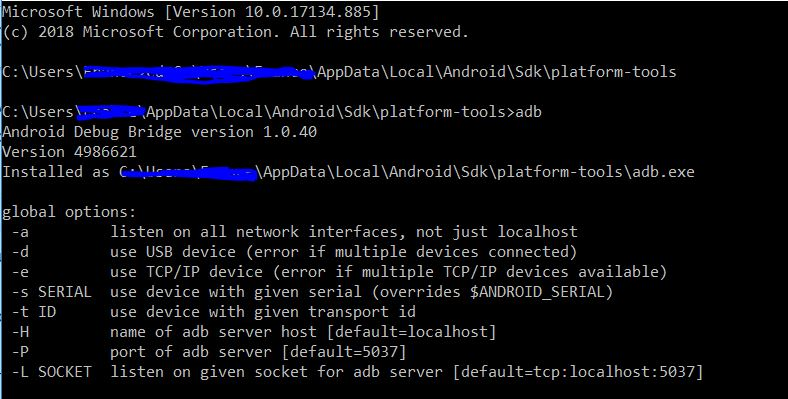


1. Run adb script shell (go to the adb directory and type 'adb')
2. Run build_android.sh (ín the same shell go to the dir where the shell file is and type build_android.sh)
3. Push the benchmark.cc file to the /data/local/temp
'C:\Users\xx\AppData\Local\Android\Sdk\platform-tools>adb push C:\Users\xx\xx\Leren\private-ai\flowers\speed_benchmark.cc /data/local/tmp
'C:\Users\xx\xx\Leren\private-ai\flowers\speed_benchmark.cc: 1 file pushed. 0.1 MB/s (6259 bytes in 0.076s)''

Make the binary executable.
adb shell chmod +x /data/local/tmp/benchmark_model      


# Convert to onnix format

Credits: I am using Pytorch tutorial code on https://pytorch.org/tutorials/advanced/super_resolution_with_caffe2.html
Github: https://pytorch.org/tutorials/_downloads/super_resolution_with_caffe2.ipynb

In [10]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.onnx
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import caffe2.python.onnx.backend as backend
import onnx

In [11]:
!dir "saved//classifier.pth"

 Volume in drive C is OS
 Volume Serial Number is 8C39-2646

 Directory of C:\Users\France\Webtotum\Leren\private-ai\flowers\saved



File Not Found


In [12]:
torch_model = models.densenet161(pretrained=False)
torch_model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['model'] == 'densenet161':
        model = models.densenet161(pretrained=False)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
      
    
    model.class_to_idx = chpt['class_to_idx']
    from collections import OrderedDict
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [21]:
model_url="saved/trained_classifier.pth"

In [22]:

# Create the super-resolution model by using the above model definition.
n_inputs = 2208
torch_model=load_model(model_url)

# set the train mode to false since we will only run the forward pass.
torch_model.train(False)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [23]:
# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

In [28]:
class_index= torch_model.class_to_idx.items()
class_index
idx_to_class = {val: key for key, val in class_index}

In [10]:
x.shape

torch.Size([1, 3, 224, 224])

In [25]:

# Export the model
torch_out = torch.onnx._export(torch_model,             # model being run
                               x,                       # model input (or a tuple for multiple inputs)
                               "saved/flower_model.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True)      # store the trained parameter weights inside the model file

Use torch_out is the output after executing the model. We use it to verify output of Caffe2

In [15]:
import json
import operator
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)


In [27]:
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object
model = onnx.load("saved/flower_model.onnx")

# prepare the caffe2 backend for executing the model this converts the ONNX model into a
# Caffe2 NetDef that can execute it. Other ONNX backends, like one for CNTK will be
# availiable soon.
prepared_backend = onnx_caffe2_backend.prepare(model)

# run the model in Caffe2

# Construct a map from input names to Tensor data.
# The graph of the model itself contains inputs for all weight parameters, after the input image.
# Since the weights are already embedded, we just need to pass the input image.
# Set the first input.
W = {model.graph.input[0].name: x.data.numpy()}

# Run the Caffe2 net:
c2_out = prepared_backend.run(W)[0]

# Verify the numerical correctness upto 3 decimal places
np.testing.assert_almost_equal(torch_out.data.cpu().numpy(), c2_out, decimal=3)

print("Exported model has been executed on Caffe2 backend, and the result looks good!")

Exported model has been executed on Caffe2 backend, and the result looks good!


# Running the model on mobile devices

After exporting themodel from PyTorch we need to load it and run it in Caffe2. Now that the model is loaded in Caffe2, we can convert it into a format suitable for running on mobile devices <https://caffe2.ai/docs/mobile-integration.html>__.

We will use Caffe2's mobile\_exporter <https://github.com/caffe2/caffe2/blob/master/caffe2/python/predictor/mobile_exporter.py>__ to generate the two model protobufs that can run on mobile. The first is used to initialize the network with the correct weights, and the second actual runs executes the model. 

### 1 Export the model to run on mobile devices

In [29]:
# extract the workspace and the model proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

``init_net`` has the model parameters and the model input embedded in it
and ``predict_net`` will be used to guide the ``init_net`` execution at
run-time. In this tutorial, we will use the ``init_net`` and
``predict_net`` generated above and run them in both normal Caffe2
backend and mobile and verify that the output high-resolution cat image
produced in both runs is the same.

For this tutorial, I will use the daisy image:

.. figure:: ../flower_photos/daisy/100080576_f52e8ee070_n.jpg
   :alt: cat

In [33]:
# Some standard imports
from caffe2.proto import caffe2_pb2
from caffe2.python import core, net_drawer, net_printer, visualize, workspace, utils

import numpy as np
import os
import subprocess
from PIL import Image
from matplotlib import pyplot
from torchvision import datasets, models, transforms

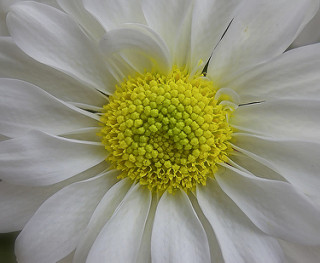

In [49]:
# load the image
# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=224),
       # transforms.CenterCrop(size=224),
       # transforms.ToTensor(),
       # transforms.Normalize([0.485, 0.456, 0.406],
             #                [0.229, 0.224, 0.225])
    ])
 
test_image = ".//flower_photos/daisy/100080576_f52e8ee070_n.jpg"

img_in = Image.open(test_image)
display(img_in)
# resize the image to dimensions 224x224
img = transform(img_in)

# save this resized image to be used as input to the model
#io.imsave("./_static/img/cat_224x224.jpg", img)
img.save(".//flower_photos/daisy/daisy_transformed.jpg")

In [57]:
img = Image.open(".//flower_photos/daisy/daisy_transformed.jpg")
img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

# Let's run the mobile nets that we generated above so that caffe2 workspace is properly initialized
workspace.RunNetOnce(init_net)
workspace.RunNetOnce(predict_net)

# Caffe2 has a nice net_printer to be able to inspect what the net looks like and identify
# what our input and output blob names are.
print(net_printer.to_string(predict_net))

torch-jit-export_predict = core.Net('torch-jit-export_predict')
torch-jit-export_predict.Conv(['input.1', '1'], ['970'], group=1, dilations=[1, 1], kernels=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2])
torch-jit-export_predict.SpatialBN(['970', '2', '3', '4', '5'], ['971'], epsilon=9.999999747378752e-06, momentum=0.8999999761581421, is_test=1)
torch-jit-export_predict.Relu(['971'], ['972'])
torch-jit-export_predict.MaxPool(['972'], ['973'], kernels=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2])
torch-jit-export_predict.SpatialBN(['973', '7', '8', '9', '10'], ['974'], epsilon=9.999999747378752e-06, momentum=0.8999999761581421, is_test=1)
torch-jit-export_predict.Relu(['974'], ['975'])
torch-jit-export_predict.Conv(['975', '12'], ['976'], group=1, dilations=[1, 1], kernels=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1])
torch-jit-export_predict.SpatialBN(['976', '13', '14', '15', '16'], ['977'], epsilon=9.999999747378752e-06, momentum=0.8999999761581421, is_test=1)
torch-jit-export_predict.Relu(['97

torch-jit-export_predict.Log(['OC2_DUMMY_80'], ['1549'])


From the above output, we can see that input is named "1" and output is named "1548"(it is a little bit weird that we will have numbers as blob names but this is because the tracing JIT produces numbered entries for the models)

In [60]:
# Now, let's also pass in the resized cat image for processing by the model.
workspace.FeedBlob("1", np.array(img_y)[np.newaxis, np.newaxis, :, :].astype(np.float32))

# run the predict_net to get the model output
workspace.RunNetOnce(predict_net)

# Now let's get the model output blob
img_out = workspace.FetchBlob("970")

Original python traceback for operator `0` in network `torch-jit-export_predict` in exception above (most recent call last):


RuntimeError: [enforce fail at conv_op_impl.h:38] C == filter.dim32(1) * G. 3 vs 1. Convolution op: input channels does not match: # of input channels 3 is not equal to kernel channels * group: 1*1
Error from operator: 
input: "input.1" input: "1" output: "970" name: "" type: "Conv" arg { name: "group" i: 1 } arg { name: "dilations" ints: 1 ints: 1 } arg { name: "kernels" ints: 7 ints: 7 } arg { name: "pads" ints: 3 ints: 3 ints: 3 ints: 3 } arg { name: "strides" ints: 2 ints: 2 } device_option { device_type: 0 device_id: 0 }(no backtrace available)